In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from scipy import stats
import pickle

In [3]:
# exp0 = pd.read_csv('results/exp_0.txt')
# exp0.head()

In [102]:
def extract_result_dict(lines2):

    k = 0
    results = {}
    results['index'] = []
    results['aux'] = []
    results['top_index'] = []
    results['score'] = []
    results['ecc'] = []
    for i,line in enumerate(lines2):
        if i==0:
            continue
        else:
            try:
                l = line.split(',')
                results['index'].append(l[0])
                results['aux'].append(parse_aux_dataframe(l[1]))
                if len(l)>=3:
                    results['top_index'].append(l[2])
                    results['score'].append(l[3])
                    results['ecc'].append(l[4])
                else:
                    results['top_index'].append(None)
                    results['score'].append(None)
                    results['ecc'].append(None)
            except:
                print(line)
                continue
    return results

def parse_results(filename, with_header=True):
    with open("results/{}".format(filename), "r") as f:
        lines = f.readlines()
        
    l = np.array([i for i,line in enumerate(lines) if line.startswith('custId')])
    freq = stats.mode(np.diff(l)).mode[0]
        
    lines2 = ['']
    l = ''
    for i,line in enumerate(lines):
        lines2[-1] += line
        if i%freq==0:
            lines2.append('')

    if lines2[-1]=='':
        lines2.pop(-1)
        
    results = extract_result_dict(lines2)
    df = pd.DataFrame(results)
    df = df.astype({'index':np.int32, 'aux':'object', 'top_index':np.int32, 'score':np.float32, 'ecc':np.float32})
    return df

def parse_aux_dataframe(s):
    l2 = s.split('\n')
    col_names = re.sub("\s\s+", " ", l2[0]).strip().split(' ')
    idx_name = l2[1].strip()
    records = [re.sub("\s\s+", " ", line).split(' ') for line in l2[2:]]

    df = pd.DataFrame(records, columns=[idx_name]+col_names).set_index(idx_name)
    return df

In [6]:
import os
filenames = sorted(os.listdir('experiment'))

experiment_map = {'2-2-3.pkl':[2,2,3],
                  '3-4-3.pkl':[3,4,3],
                  '6-8-3.pkl':[6,8,3],
                  '2-2-14.pkl':[2,2,14],
                  '3-4-14.pkl':[3,4,14],
                  '6-8-14.pkl':[6,8,14]}

experiments = {}

for filename in filenames:
#     df = parse_results(filename, with_header=True)
    try:
        f = open('experiment/'+filename, "rb")
        results = pickle.load(f)
        f.close
        print('nb experiments for {}: {}'.format(filename, len(results)))
        experiments[filename] = results
    except:
        print('parsing failed for {}'.format(filename))
        continue

nb experiments for 2-2-14.pkl: 1000
nb experiments for 2-2-3.pkl: 1000
nb experiments for 3-4-14.pkl: 1000
nb experiments for 3-4-3.pkl: 1000
nb experiments for 6-8-14.pkl: 1000
nb experiments for 6-8-3.pkl: 1000


In [42]:
statistics = {'nb_movies':[], 'days':[], 'proba':[]}
for filename, results in experiments.items():
    print('experiment {}'.format(experiment_map[filename]))
    print(sum([r['id'] == r['matchedId'] for r in results])/len(results))
    succ_thresh = sum([(r['id'] == r['matchedId'])&(r['eccentricity']>=1.5) for r in results])/len(results)
    print(succ_thresh)
    l = experiment_map[filename]
    statistics['nb_movies'].append('{}-{}'.format(l[0],l[1]))
    statistics['days'].append(l[2])
    statistics['proba'].append(succ_thresh)

experiment [2, 2, 14]
0.432
0.154
experiment [2, 2, 3]
0.68
0.255
experiment [3, 4, 14]
0.773
0.422
experiment [3, 4, 3]
0.906
0.544
experiment [6, 8, 14]
0.986
0.826
experiment [6, 8, 3]
0.996
0.907


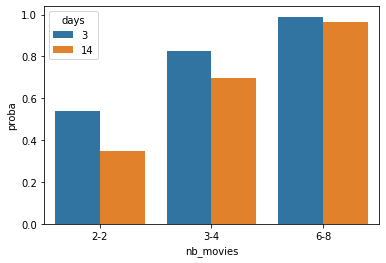

In [41]:
df = pd.DataFrame(statistics)#.set_index(['nb_movies', 'days']).unstack()
sns.barplot(x='nb_movies', y='proba', hue='days', data=df)

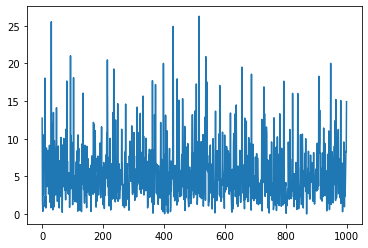

In [14]:
plt.plot([r['eccentricity'] for r in results])

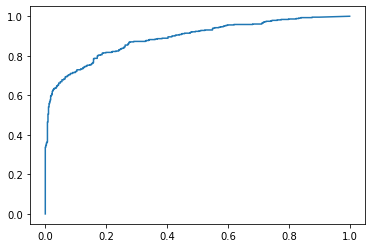

In [37]:
from sklearn.metrics import roc_curve

results = experiments['2-2-14.pkl']

y_true = [(r['id'] == r['matchedId']) for r in results]
y_score = [r['eccentricity'] for r in results]
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.plot(fpr, tpr)

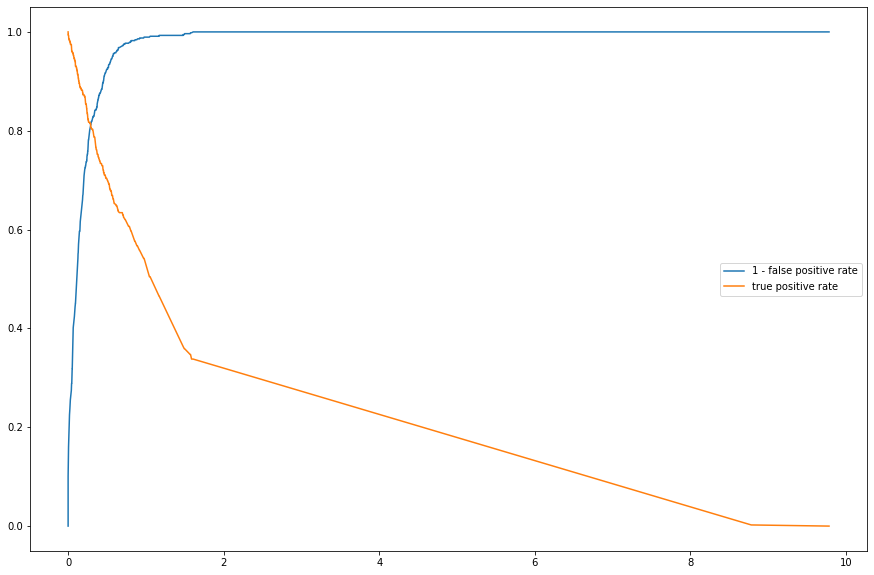

In [38]:
plt.figure(figsize=(15,10))
plt.plot(thresholds, 1 - fpr, label="1 - false positive rate")
plt.plot(thresholds, tpr, label="true positive rate")
plt.legend()

In [39]:
for tpr_, fpr_, thresh in zip(tpr, fpr, thresholds):
    if tpr_ > 1-fpr_:
        print("{} | {} => {}".format(tpr_, fpr_, thresh))
        break

0.8125 | 0.19014084507042253 => 0.28881187609790143
